# 1. Importing Libraries
---

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries
from sklearn.model_selection import StratifiedKFold, cross_val_predict, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from scipy.stats import loguniform

# Avoid warnings to show-up
import warnings
warnings.filterwarnings('ignore')

# 2. Data Investigation
---

In [2]:
# Make sure both ipynb and csv files are in the same directory
raw = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
raw

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [4]:
# The dataset contains 7043 rows and 21 columns, which is not very big
# Therefore I will use K-Fold Cross Validation instead of Train-Test Split (10 folds)
# Too few numeric columns
# No Missing values for now

raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# raw['TotalCharges'] = raw['TotalCharges'].astype('float32') - Error raised because of Empty strings in the column

# Check for empty strings in string columns (if there is any other column other than TotalCharges)

string_columns = raw.select_dtypes(include=['object']).columns
for col in string_columns:
    empty_count = (raw[col].astype(str).str.strip() == "").sum()
    if empty_count > 0:
        print(f"Column '{col}' has {empty_count} empty strings.")

Column 'TotalCharges' has 11 empty strings.


In [6]:
cleaned = raw.copy()

cleaned['TotalCharges'] = cleaned['TotalCharges'].str.strip()
cleaned['TotalCharges'] = cleaned['TotalCharges'].replace('', np.nan)
cleaned['TotalCharges'] = cleaned['TotalCharges'].astype('float')
cleaned['TotalCharges'].isnull().sum()

# Once empty strings are now NaN

np.int64(11)

In [7]:
cleaned['AvgMonthlyCharges'] = cleaned['TotalCharges'] / cleaned['tenure']
cleaned['MonthlyChargesCheck'] = cleaned['MonthlyCharges'] == cleaned['AvgMonthlyCharges']
cleaned['MonthlyChargesCheck'].value_counts()

# It seems that MontlyCharges are not exactly equal to TotalCharges / tenure
# I was planning to impute null values in TotalCharges with MonthlyCharges * tenure

MonthlyChargesCheck
False    6429
True      614
Name: count, dtype: int64

In [8]:
cleaned[cleaned['TotalCharges'].isnull()]['tenure'].value_counts()

# All NULL values in TotalCharges correspond to tenure = 0

tenure
0    11
Name: count, dtype: int64

In [9]:
len(cleaned[cleaned['tenure'] == 0])

# All tenure = 0 values correspond to NULL values in TotalCharges
# Hence, I will impute TotalCharges with 0 as the customers with tenure 0 should not have been charged anything yet

imputed = cleaned.copy()
imputed['TotalCharges'] = imputed['TotalCharges'].fillna(0)

In [10]:
# These two columns sounds similar, I will check if they are identical
# It seems that they are closed to be identical, but not exactly (collinearity alert for later, l2 penalty might be a good idea)

imputed[['StreamingTV', 'StreamingMovies']].value_counts()

StreamingTV          StreamingMovies    
No                   No                     2018
Yes                  Yes                    1940
No internet service  No internet service    1526
No                   Yes                     792
Yes                  No                      767
Name: count, dtype: int64

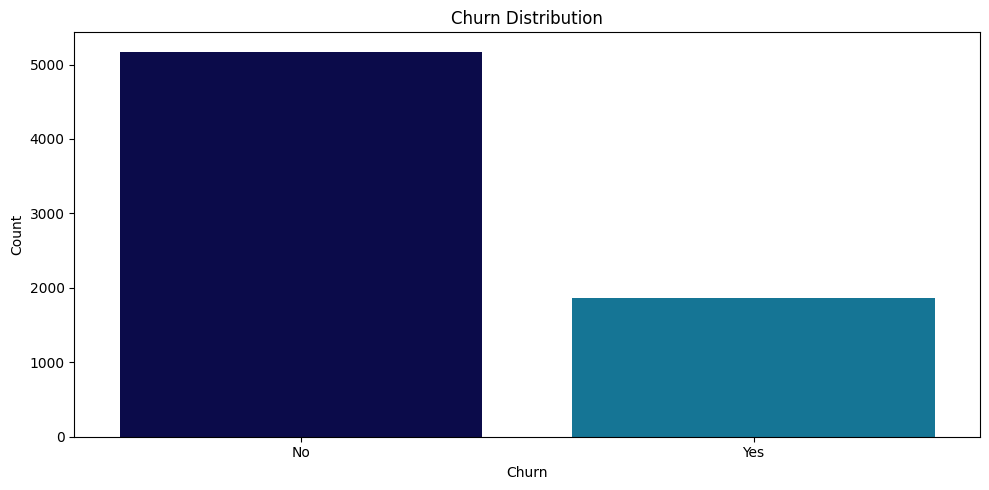

In [11]:
plt.figure(figsize=(10,5))
sns.barplot(x=cleaned['Churn'].value_counts().index, y=cleaned['Churn'].value_counts().values, palette='ocean')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Churn Distribution')
plt.tight_layout()

# Imbalanced dataset -> Stratified K-Fold Cross Validation will be used

In [12]:
# Let's get the categorical features
categorical_features = imputed.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('Churn')  # Target variable

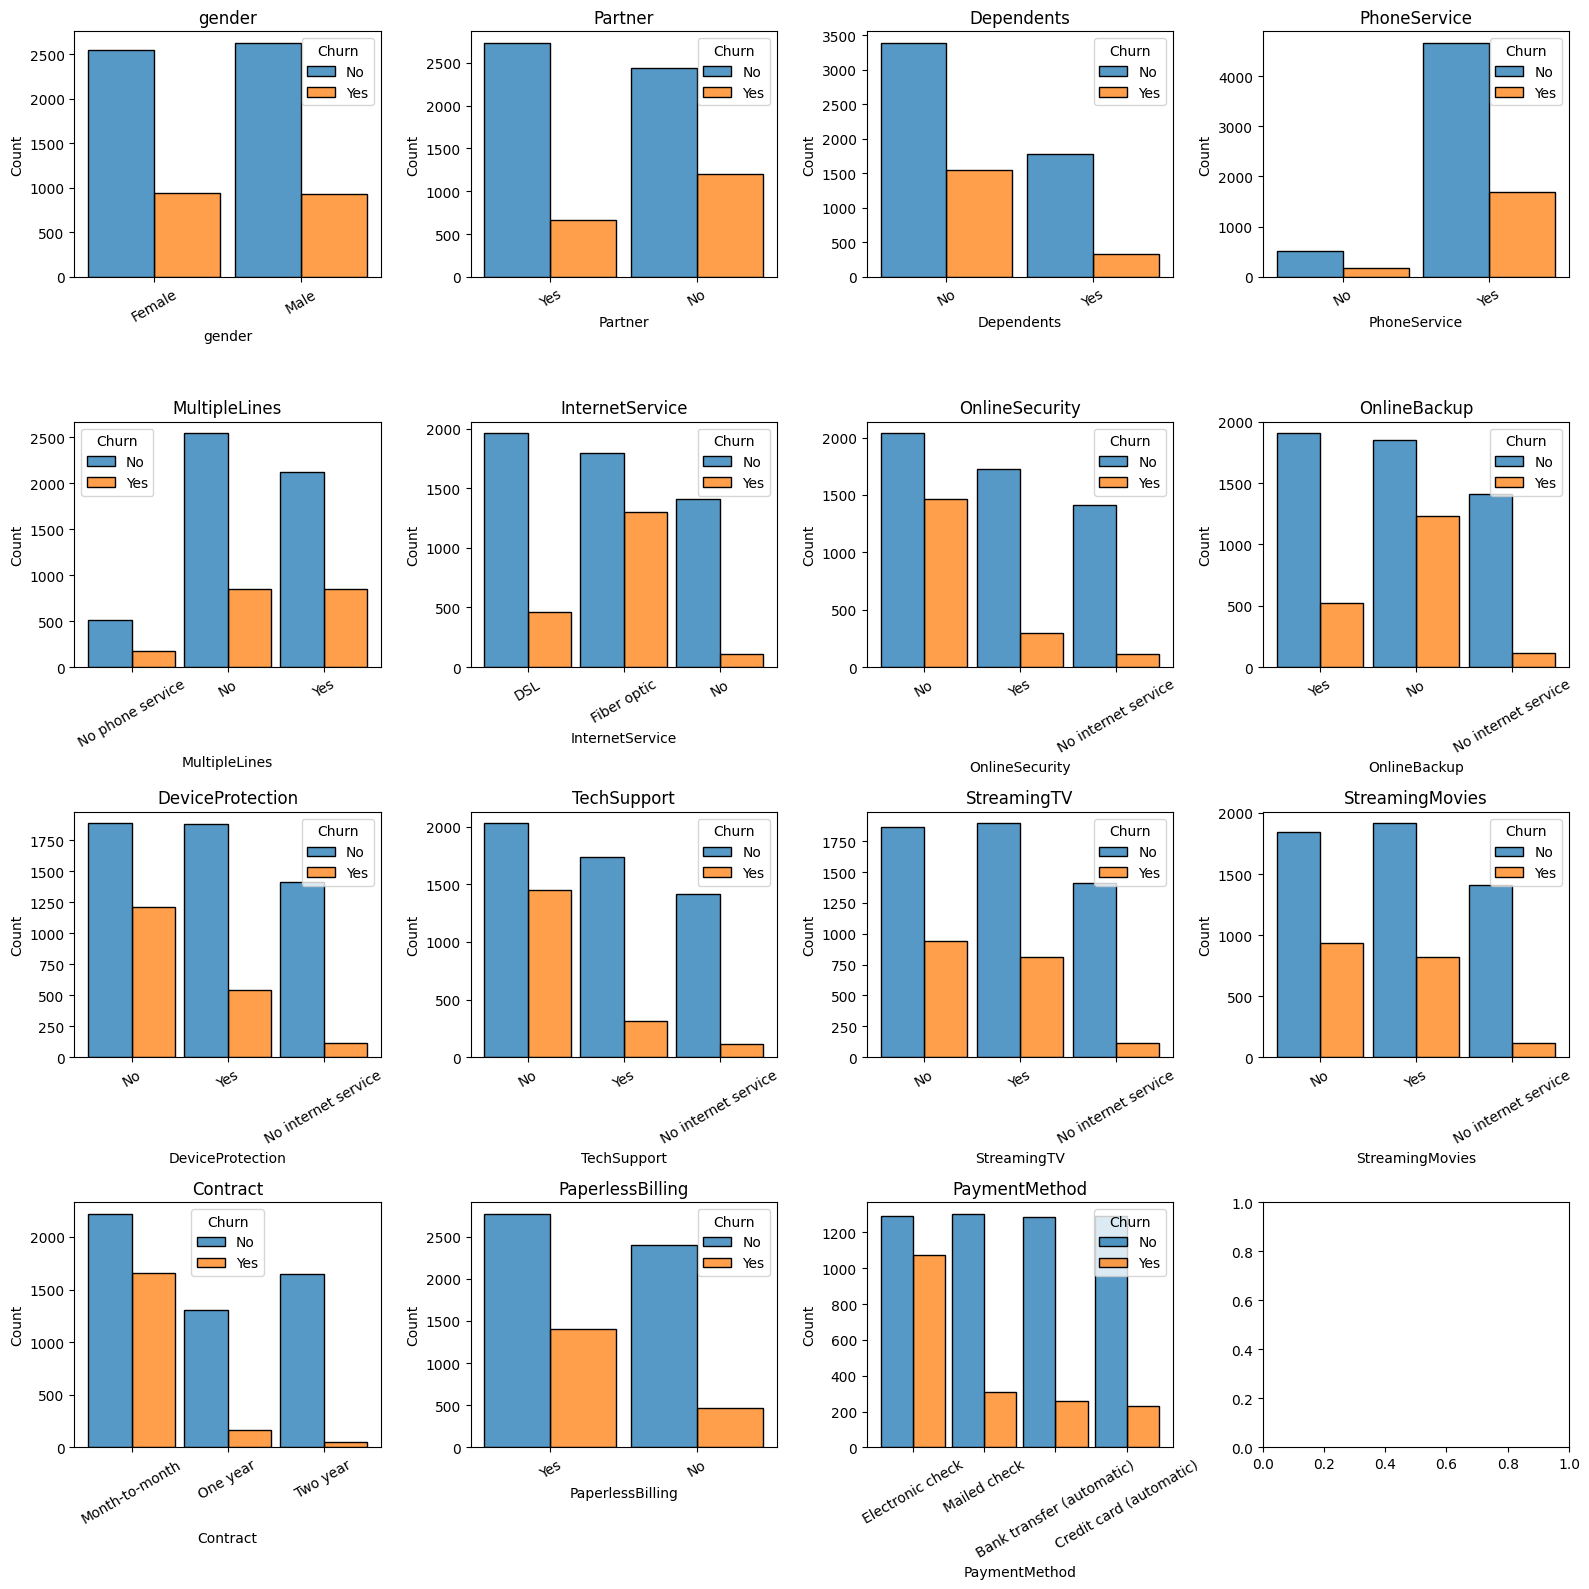

In [13]:
# We have imbalanced Churn distribution, let's see how other features distribute with respect to Churn
fig, axes = plt.subplots(4, 4, figsize=(16,16))
axes = axes.flatten()

for i, feature in enumerate(categorical_features[1:]):  # Exclude 'customerID'
    sns.histplot(
        data=imputed,
        x=feature,
        hue="Churn",
        multiple="dodge",
        shrink=0.9,
        ax=axes[i]
    )
    axes[i].set_title(feature)
    axes[i].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

# Some features seems to have a strong correlation with Churn (Contract, PaymentMethod, InternetService, TechSupport, OnlineSecurity, OnlineBackup)
# Therefore, It will be OK to create new binary features



imputed['is_Month_to_month'] = (imputed['Contract'] == 'Month-to-month')
imputed['is_Month_to_month'] = imputed['is_Month_to_month'].replace({True: 'Yes', False: 'No'})

imputed['is_ElectronicCheck'] = (imputed['PaymentMethod'] == 'Electronic check')
imputed['is_ElectronicCheck'] = imputed['is_ElectronicCheck'].replace({True: 'Yes', False: 'No'})

imputed['is_FiberOptic'] = (imputed['InternetService'] == 'Fiber optic')
imputed['is_FiberOptic'] = imputed['is_FiberOptic'].replace({True: 'Yes', False: 'No'})

imputed['is_NoTechSupport'] = (imputed['TechSupport'] == 'No')
imputed['is_NoTechSupport'] = imputed['is_NoTechSupport'].replace({True: 'Yes', False: 'No'})

imputed['is_NoOnlineSecurity'] = (imputed['OnlineSecurity'] == 'No')
imputed['is_NoOnlineSecurity'] = imputed['is_NoOnlineSecurity'].replace({True: 'Yes', False: 'No'})

imputed['is_NoOnlineBackup'] = (imputed['OnlineBackup'] == 'No')
imputed['is_NoOnlineBackup'] = imputed['is_NoOnlineBackup'].replace({True: 'Yes', False: 'No'})

imputed = imputed.drop(columns=['PaymentMethod', 'Contract', 'InternetService', 'TechSupport', 'OnlineSecurity','OnlineBackup'])

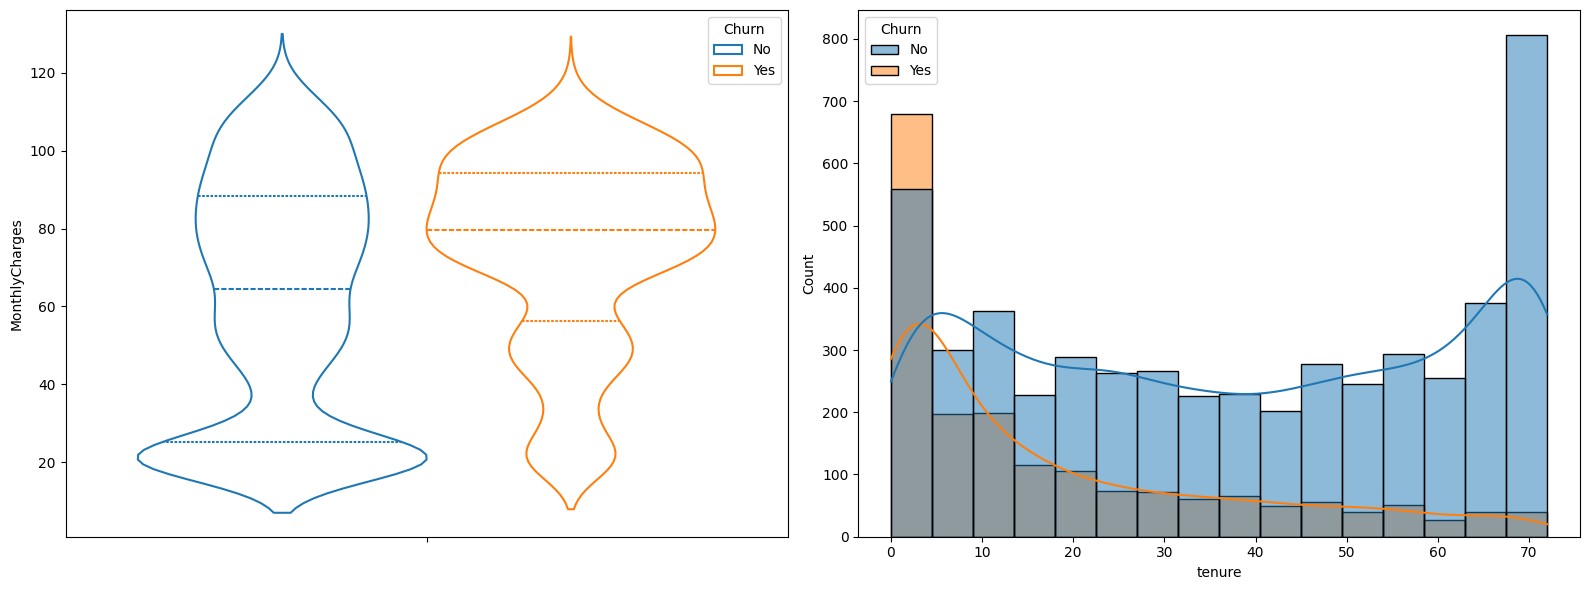

In [ ]:
fig , ax = plt.subplots(1,2, figsize=(16,6))
sns.violinplot(data=imputed, y='MonthlyCharges',hue='Churn', ax=ax[0], fill=False, inner="quartile");
sns.histplot(data=imputed, x='tenure', hue='Churn', kde=True,alpha=0.5, ax=ax[1]);
plt.tight_layout()

# Churned customers tend to have higher MonthlyCharges and lower tenure
# Let's combine the two features impact into a new feature

imputed['MonthlyCharges_per_tenure'] = imputed['MonthlyCharges'] / (imputed['tenure'] + 1)


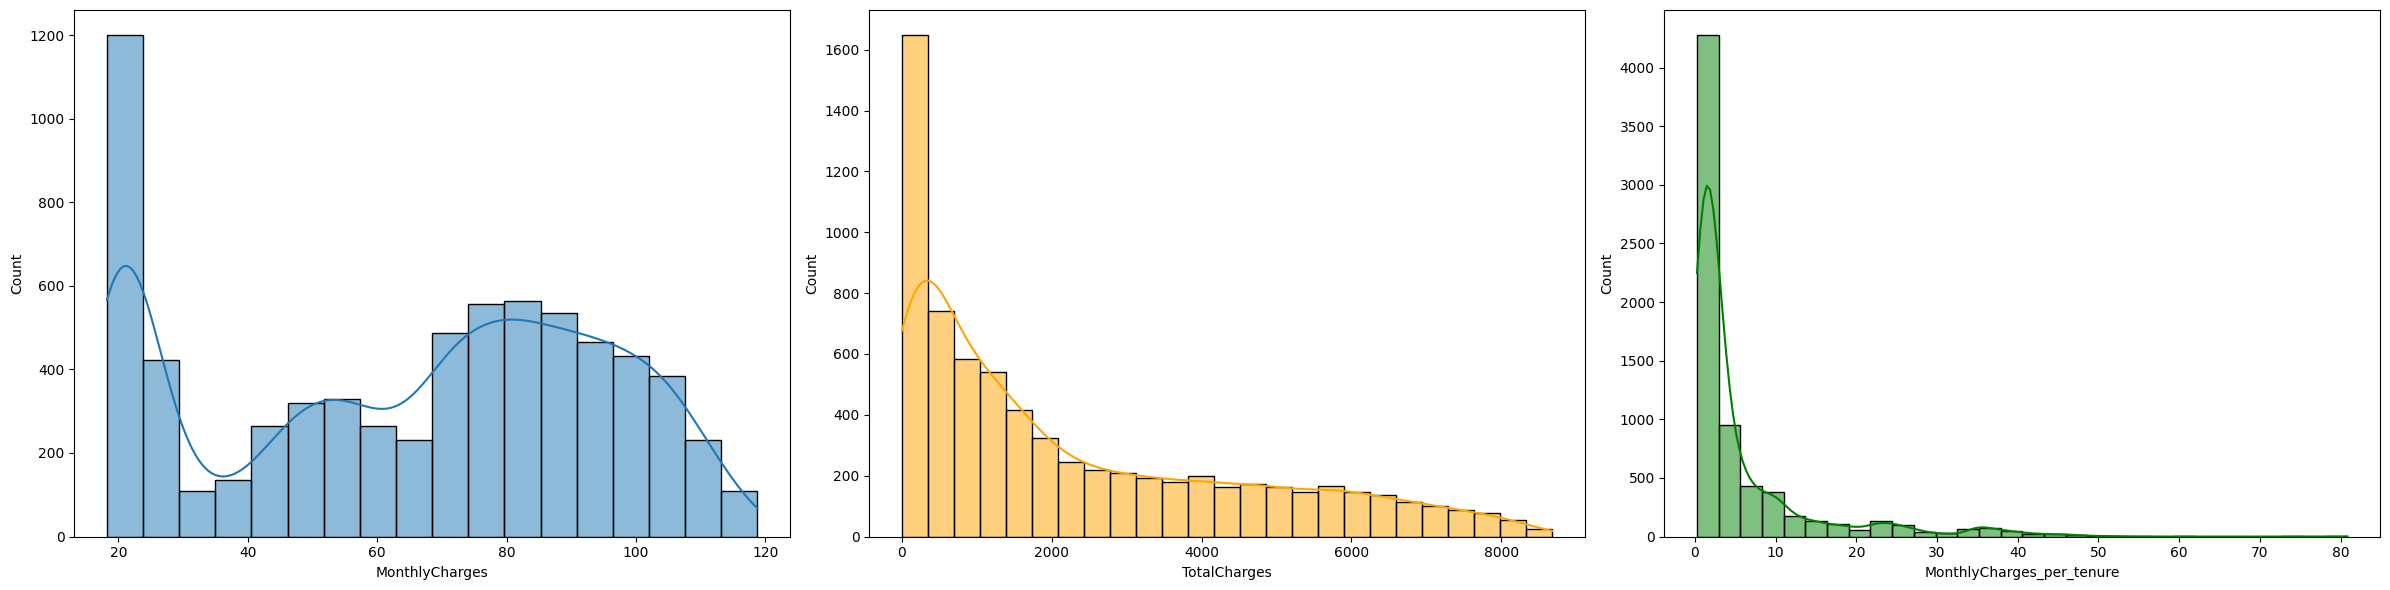

In [15]:
fig , ax = plt.subplots(1,3, figsize=(24,6))
sns.histplot(imputed['MonthlyCharges'], ax=ax[0], kde=True);
sns.histplot(imputed['TotalCharges'], ax=ax[1], kde=True, color='orange');
sns.histplot(imputed['MonthlyCharges_per_tenure'],bins=30, ax=ax[2], kde=True, color='green');
plt.tight_layout()

# Although TotalCharges and MonthlyCharges_per_tenure is right-skewed, MonthlyCharges distribution is multi-modal
# Therefore, applying log transformation to both blindly might not be a good idea to obtain normality
# I will instead use PowerTransformer for both columns

# 3. Data Preprocessing
---

* As a matter of fact a part of data preprocessing have already been done (Imputation of Missing Total Charges)

* Furthermore, some feature engineering has been done (Monthly charges per tenure, and is_electronicCheck, etc...)

* Data Investigation part shows that there are multiple columns might result in collinearity, so L2 (Ridge) will be applied

* Below will be structured pipelines per model type

* I will use Logistic Regression (baseline), Support Vector Machines (better with small-mid sized data like this), and Naive Bayes (Pure experimental) as non-Tree based models:

    * I will first Power Transform continuous variables: Monthly Charges, Total Monthly Charges
    * Then standard scale will be applied upon all numericals (continuous + discrete (tenure))
    * One-Hot Encoding (OHE) for Categoricals

* Random Forest and XGBoost are going to be my candidate Tree-Based Models for this task.

    * Only OHE because of scikit-learn prerequisite of handling categoricals

## 3.1 General Hygiene

In [16]:
# Let's first drop previously created columns
imputed = imputed.drop(columns=['AvgMonthlyCharges', 'MonthlyChargesCheck'])

In [17]:
# Let's convert SeniorCitizen back to categorical as it is a binary categorical variable
imputed['SeniorCitizen'] = imputed['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

In [18]:
# Let's also drop customerID as it is not useful for prediction
imputed.drop(columns=['customerID'], inplace=True)

In [ ]:
# Let's not forget to create numerical features' lists
continuous_numerical_features = ['MonthlyCharges', 'TotalCharges', 'MonthlyCharges_per_tenure']
discrete_numerical_features = ['tenure']

categorical_features = imputed.select_dtypes(include=['object']).columns.tolist() # Updating categorical features list after dropping some columns
categorical_features.remove('Churn')  # Target variable

## 3.2 Non-Tree Pipeline

In [20]:
# Power Transformation is applied to make the distribution more Gaussian-like (log-transformation might not be reasonable for multi-modal distributions)
# Method is Yeo-Johnson as it supports zero values as well (zero TotalCharges values exist)
# Standard Scaling is done inherently due to standardization=True as default in PowerTransformer which is also required to bring all features to a similar scale (required for inter-feature impact)

continuous_transformer = Pipeline(steps=[
    ('power', PowerTransformer(method='yeo-johnson', standardize=True))
])

# Scaling is required to bring all features to a similar scale (required for inter-feature impact)
discrete_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Nominal features are one-hot encoded
nominal_transformer = Pipeline(steps=[
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

In [21]:
preprocessor_non_tree = ColumnTransformer(
    transformers=[
        ('continuous', continuous_transformer, continuous_numerical_features),
        ('discrete', discrete_transformer, discrete_numerical_features),
        ('categorical', nominal_transformer, categorical_features)
    ],
    remainder='passthrough'
)

## 3.3 Tree Pipeline

In [22]:
# Nominal features are only one-hot encoded (required due to scikit-learn's handling of categorical variables in tree-based models)
nominal_transformer = Pipeline(steps=[
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [23]:
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# 4. Modelling
---

In [24]:
# Let's convert Churn to binary 0-1 variable for later use
imputed['Churn'] = imputed['Churn'].replace({'No': 0, 'Yes': 1})

In [25]:
# Set X and y for modelling
X = imputed.drop(columns=['Churn'])
y = imputed['Churn']


# Stratified K-Fold Cross Validation to maintain the same proportion of classes in each fold as in the entire dataset
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [26]:
# Model Pipelines

nb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_non_tree),
    ('classifier', GaussianNB())
])

logr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_non_tree),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_non_tree),
    ('classifier', SVC(random_state=42, class_weight='balanced', probability=True))
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

In [27]:
# Hyperparameter pool for Randomized Search CV for each model
# Value distributions are chosen based on common practices and the specific dataset characteristics

nb_param_dist = {
    'classifier__var_smoothing': np.logspace(0, -9, num=100)
}

logr_param_dist = {
    'classifier__C': np.logspace(-3, 2, 20),
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__l1_ratio': np.linspace(0, 1, 10),
    "classifier__solver": ["saga"]
}

svm_param_dist = {
    'classifier__C': np.logspace(-2, 2, 10),
    'classifier__kernel': ['rbf','linear'],
    'classifier__gamma': ['scale', 'auto']
}

rf_param_dist = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [None, 5, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None]
}

xgb_param_dist = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 0.9],
    'classifier__colsample_bytree': [0.6, 0.8, 0.9],
    'classifier__scale_pos_weight': [sum(y==0)/sum(y==1)],
    'classifier__reg_alpha': loguniform(1e-2, 1e0),       
    'classifier__reg_lambda': loguniform(1e-2, 1e1),      
    'classifier__gamma': loguniform(1e-3, 0.5)            
}

In [28]:
# Dictionary to hold all pipelines and their corresponding hyperparameter distributions
searches = {    
    'Naive Bayes': (nb_pipeline, nb_param_dist),
    'Logistic Regression': (logr_pipeline, logr_param_dist),
    'Support Vector Machine': (svm_pipeline, svm_param_dist),
    'Random Forest': (rf_pipeline, rf_param_dist),
    'XGBoost': (xgb_pipeline, xgb_param_dist)
}

In [29]:
# Running Randomized Search CV for each model and storing the best estimators

best_estimators = {}

for name, (pipeline, params) in searches.items():
    
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=params,
        n_iter=10,
        cv=skf,
        scoring='roc_auc',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    random_search.fit(X, y)


    print(f"Best ROC AUC: {random_search.best_score_:.4f}")  
    print(f"Best [{name}] parameters: ", random_search.best_params_)
    print(150 * "=","\n")

    best_estimators[name] = random_search.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best ROC AUC: 0.8370
Best [Naive Bayes] parameters:  {'classifier__var_smoothing': np.float64(1.0)}

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best ROC AUC: 0.8482
Best [Logistic Regression] parameters:  {'classifier__solver': 'saga', 'classifier__penalty': 'elasticnet', 'classifier__l1_ratio': np.float64(0.4444444444444444), 'classifier__C': np.float64(0.23357214690901212)}

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best ROC AUC: 0.8431
Best [Support Vector Machine] parameters:  {'classifier__kernel': 'rbf', 'classifier__gamma': 'auto', 'classifier__C': np.float64(0.027825594022071243)}

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best ROC AUC: 0.8448
Best [Random Forest] parameters:  {'classifier__n_estimators': 400, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 5}

Fitting 10 

In [30]:
results = {}
for name in best_estimators.keys():
    y_pred = cross_val_predict(best_estimators[name], X, y, cv=skf)
    y_proba = cross_val_predict(best_estimators[name], X, y, cv=skf, method='predict_proba')[:, 1]

    results[name] = {
            'ROC AUC': roc_auc_score(y, y_proba),
            'F1-Score': f1_score(y, y_pred),
            'Accuracy': accuracy_score(y, y_pred),
            'Precision': precision_score(y, y_pred),
            'Recall': recall_score(y, y_pred),
            'Confusion Matrix': confusion_matrix(y, y_pred)
        }
    
results_df = pd.DataFrame(results).T
results_df

# It seems that Naive Bayes is not that bad after all even though its assumptions are violated here
# Logistic Regression and XGBoost are performing the best, and as a matter of fact they are performing very similarly
# I am surprised that Logistic Regression is performing that well, I was expecting XGBoost to outperform it by a larger margin
# Recall scores are good, however Precision scores are not that good, meaning that there are a lot of False Positives
# Meaning that the models capture most of the Churned customers, however they also classify some of Non-Churned customers as Churned too
# Depending on the business case, this might be acceptable as long as most of the Churned customers are captured
# However, I will try to improve Precision scores as well by tuning the classification threshold (if possible)

,ROC AUC,F1-Score,Accuracy,Precision,Recall,Confusion Matrix
Naive Bayes,0.83703,0.628402,0.769274,0.548722,0.735152,"[[4044, 1130], [495, 1374]]"
Logistic Regression,0.847964,0.638829,0.761749,0.53439,0.794007,"[[3881, 1293], [385, 1484]]"
Support Vector Machine,0.842901,0.625787,0.746983,0.515036,0.797218,"[[3771, 1403], [379, 1490]]"
Random Forest,0.844246,0.629948,0.749113,0.51755,0.804708,"[[3772, 1402], [365, 1504]]"
XGBoost,0.847086,0.62948,0.751952,0.521434,0.794007,"[[3812, 1362], [385, 1484]]"


# 5. Fine Tuning Logistic Regression
---

In [31]:
# Let's get the probability values from the best model: Logistic Regression
# These probability values will be used to plot Precision-Recall curve and tune the classification threshold if possible

logr_proba = cross_val_predict(best_estimators['Logistic Regression'], X, y, cv=skf, method='predict_proba')[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y, logr_proba)


In [32]:
# Calculate F1 score for each threshold (excluding threshold=1)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-9)

# Detecting the optimal threshold that gives the highest F1 score
best_f1_score_index = np.argmax(f1_scores)
optimal_threshold = thresholds[best_f1_score_index]
best_f1_score = f1_scores[best_f1_score_index]

print(f"Default Threshold: 0.5000 F1-Score: {results_df.loc['Logistic Regression', 'F1-Score']}")
print(f"Optimal Threshold: {optimal_threshold:.4f} F1-Score: {best_f1_score}")

# From the values it seems that the optimal threshold is very close to the default 0.5 threshold
# Therefore, I will not change the classification threshold and keep it at 0.5
# It seems that the models are at their limits and there is not much room for improvement in terms of Precision and Recall balance
# More data and/or ensemble methods (Stacking/Voting) might help to improve the performance further

Default Threshold: 0.5000 F1-Score: 0.6388291003013344
Optimal Threshold: 0.5004 F1-Score: 0.6389666303048551
